In [1]:
# !pip install --upgrade jax jaxlib # CPU-only
!pip install flax
!pip install optax

     |████████████████████████████████| 176 kB 24.9 MB/s 
     |████████████████████████████████| 136 kB 65.0 MB/s 
     |████████████████████████████████| 65 kB 4.8 MB/s 


In [2]:
import os 
import datetime
import random
from functools import partial
from typing import Any, Callable, Dict, List, Optional, Tuple

from google.colab import drive
drive.mount('/content/drive')

import matplotlib
import matplotlib.pyplot as plt
import pickle
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
import optax
import flax.linen as nn
from flax import serialization
from flax.training import train_state
from scipy.special import expit

# For dataloader only
import torch
import torchvision

print('Using:', jax.default_backend())

Mounted at /content/drive
Using: gpu


In [3]:
# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!
# https://robertbrucecarter.com/writing/2020/06/setting-your-working-directory-to-google-drive-in-a-colab-notebook/

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Grad School/JAX/AFA"

def create_and_set_working_directory(project_folder):
    # check if your project folder exists. if not, it will be created.
    if os.path.isdir(root_dir + project_folder) == False:
        os.mkdir(root_dir + project_folder)
        print(root_dir + project_folder + ' did not exist but was created.')

    # change the OS to use your project folder as the working directory
    os.chdir(root_dir + project_folder)

    # create a test file to make sure it shows up in the right place
    print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)
!pwd
!touch 'results/_last_access.txt'
with open('results/_last_access.txt', 'w') as f:
    f.write(f'Last run at: {datetime.datetime.now()}')


Your working directory was changed to /content/drive/My Drive/Grad School/JAX/AFA

An empty text file was created there. You can also run !pwd to confirm the current working directory.
/content/drive/My Drive/Grad School/JAX/AFA


In [4]:
def save_grad_heatmap(grads, iter, grad_path_partial='samples/grads'):
    grad_path_full = os.path.join(grad_path_partial, str(iter))
    os.makedirs(grad_path_full, exist_ok=True)

    for index, grad in enumerate(grads[:50]):
        grad = grad.reshape(28,28)
        matplotlib.image.imsave(os.path.join(grad_path_full, f'grad_{index}.png'), grad, cmap='plasma')

def save_some_digits(X, mask, iter, img_path_partial='samples/acquired'):
    img_path_full = os.path.join(img_path_partial, str(iter))
    os.makedirs(img_path_full, exist_ok=True)

    for index, (digit, digit_mask) in enumerate(zip(X[:50], mask[:50])):
        digit = digit.reshape(28,28)
        digit_mask = digit_mask.reshape(28,28)

        partial_digit = \
            0.8*np.stack([digit_mask*digit, digit_mask*digit, digit], axis=-1) + \
            0.2*np.expand_dims(digit_mask, axis=-1)

        matplotlib.image.imsave(os.path.join(img_path_full, f'digit_{index}.png'), partial_digit)

def save_preds(preds, iter, pred_path_partial='samples/preds'):
    pred_path_full = os.path.join(pred_path_partial, str(iter))
    os.makedirs(pred_path_full, exist_ok=True)
    
    for index, pred in enumerate(preds[:50]):
        plt.bar(range(10), pred)
        plt.savefig(os.path.join(pred_path_full, f'pred_{index}'))
        plt.clf()

def show_grad_heatmap(grads):
    plt.figure(figsize=(25,12))

    # Go over the first 10 data points
    for index, grad in enumerate(grads[:10]):
        plt.subplot(2, 5, index + 1)
        plt.imshow(grad.reshape(28,28), cmap='plasma')

def show_some_digits(X, mask):
    plt.figure(figsize=(25,12))

    for index, (digit, digit_mask) in enumerate(zip(X[:5], mask[:5])):
        digit = digit.reshape(28,28)
        digit_mask = digit_mask.reshape(28,28)

        plt.subplot(4, 5, index + 1)
        plt.imshow(digit, cmap=plt.cm.gray)

        partial_digit = \
            0.8*np.stack([digit_mask*digit, digit_mask*digit, digit], axis=-1) + \
            0.2*np.expand_dims(digit_mask, axis=-1)
        plt.subplot(4, 5, index + 6)
        plt.imshow(partial_digit)

    for index, (digit, digit_mask) in enumerate(zip(X[5:], mask[5:])):
        digit = digit.reshape(28,28)
        digit_mask = digit_mask.reshape(28,28)

        plt.subplot(4, 5, index + 11)
        plt.imshow(digit, cmap=plt.cm.gray)

        # 0.8*true unseen digit in blue + 0.2*acquired features in white
        partial_digit = \
            0.8*np.stack([digit_mask*digit, digit_mask*digit, digit], axis=-1) + \
            0.2*np.expand_dims(digit_mask, axis=-1)
        plt.subplot(4, 5, index + 16)
        plt.imshow(partial_digit)

def show_preds(preds):
    plt.figure(figsize=(25,12))

    for index, pred in enumerate(preds[:10]):
        plt.subplot(2, 5, index + 1)
        plt.bar(range(10), pred)

def make_it_noisy(X, drop_probability):
    # This is how we create the noisy data set
    return np.multiply(X, np.random.choice([0, 1], size=X.shape, p=[drop_probability, 1 - drop_probability]))

In [5]:
class MNISTCustom(torchvision.datasets.MNIST):
    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,):
        super(MNISTCustom, self).__init__(root, train=train, transform=transform,
                                          target_transform=target_transform, 
                                          download=download)

        # load as numpy
        self.data = self.data.detach().cpu().numpy().reshape(-1,28,28,1)/255
        self.targets = self.targets.cpu().numpy()

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        return self.data[index], int(self.targets[index])

In [6]:
# Axis at end so (bs, h, w, channels)
collate_fn = lambda datalist: (np.stack([data[0] for data in datalist], axis=0), 
                               np.stack([data[1] for data in datalist], axis=0))

num_features = 784
train_bs = 64
train_set_size = 60000
test_bs = 5000
test_set_size = 10000
train_loader = torch.utils.data.DataLoader(
    MNISTCustom('', train=True, download=True,),
    batch_size=train_bs,
    shuffle=False,
    collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(
    MNISTCustom('', train=False, download=True,),
    batch_size=test_bs,
    shuffle=False,
    collate_fn=collate_fn)

In [7]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x, train=True):
        x = nn.Conv(features=10, kernel_size=(5, 5), padding='valid')(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.relu(x)
        x = nn.Conv(features=20, kernel_size=(5, 5), padding='valid')(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2)) # https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
        x = nn.relu(x)
        x = x.reshape((x.shape[0], 320))  # flatten
        x = nn.Dense(features=150)(x)
        x = nn.relu(x)
        x = nn.Dropout(0.5)(x, deterministic=not train)
        x = nn.Dense(features=70)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.relu(x)
        x = nn.log_softmax(x)
        return x

In [8]:
# Source: https://github.com/google/flax/blob/main/examples/mnist/train.py

# https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError
# Make train a static argument
@partial(jit, static_argnums=[4,]) 
def apply_model(state, images, labels, rngs, train):
    """Computes gradients, loss and accuracy for a single batch."""
    def loss_fn(params):
        logits = CNN().apply({'params': params}, images, train=train, rngs=rngs)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy

@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

def train_epoch(state, train_loader, batch_size, rngs):
    epoch_loss = []
    epoch_accuracy = []
    
    for i, (x, y) in enumerate(train_loader):
        # Train on noisy samples
        p = random.uniform(0.4, 1)
        if p > 0.8: p = 0
        
        grads, loss, accuracy = apply_model(state, make_it_noisy(x, p), y, rngs, train=True)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)

    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy

def create_train_state(rngs, config):
    """Creates initial `TrainState`."""
    cnn = CNN()
    params = cnn.init(rngs, jnp.ones([1, 28, 28, 1]))['params']
    tx = optax.adam(config['learning_rate'])
    return train_state.TrainState.create(
        apply_fn=cnn.apply, params=params, tx=tx)

In [9]:
model = CNN()

In [10]:
config = {
    'num_epochs': 2,
    'batch_size': 64,
    'learning_rate': 1e-3,
}
num_epochs = 6
batch_size = 64

In [16]:
# Setup for training
np.random.seed(0)
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
rng, dropout_rng = jax.random.split(rng)
rngs = {
    'params': init_rng,
    'dropout': dropout_rng
}
state = create_train_state(rngs, config)

# Training loop
for epoch in range(1, num_epochs + 1):
    rng, dropout_rng = jax.random.split(rng)
    rngs_iter = {'dropout': dropout_rng,}
    state, train_loss, train_accuracy = train_epoch(state, train_loader,
                                                    batch_size,
                                                    rngs_iter)
    x_test, y_test = next(iter(test_loader))
    _, test_loss, test_accuracy = apply_model(state, x_test,
                                              y_test, rngs_iter, 
                                              train=False)
    print('epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f, test_accuracy: %.2f'
        % (epoch, train_loss, train_accuracy * 100, test_loss,
           test_accuracy * 100))
    

epoch:  1, train_loss: 0.5062, train_accuracy: 84.00, test_loss: 0.1601, test_accuracy: 95.28
epoch:  2, train_loss: 0.2290, train_accuracy: 92.95, test_loss: 0.1303, test_accuracy: 96.26
epoch:  3, train_loss: 0.1887, train_accuracy: 94.11, test_loss: 0.0974, test_accuracy: 97.16
epoch:  4, train_loss: 0.1658, train_accuracy: 94.95, test_loss: 0.0807, test_accuracy: 97.28
epoch:  5, train_loss: 0.1578, train_accuracy: 95.05, test_loss: 0.0767, test_accuracy: 97.54
epoch:  6, train_loss: 0.1479, train_accuracy: 95.43, test_loss: 0.0720, test_accuracy: 97.74


In [21]:
# https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html#Serializing-the-result
bytes_output = serialization.to_bytes(state.params)
with open('model.dat', 'wb') as f:
    f.write(bytes_output)

In [22]:
# AFA stuff
def forward_func(image, params, rngs): 
    # Will vmap this later, so assume image is one sample rather than batch
    return jnp.linalg.norm(CNN().apply({'params': state.params}, jnp.expand_dims(image, 0), train=False, rngs=rngs)[0], axis=0)

def pred(images, params, rngs):
    return CNN().apply({'params': state.params}, images, train=False, rngs=rngs)

def accuracy(images, labels, params, rngs):
    logits = pred(images, params, rngs)
    accuracy = np.mean(np.argmax(logits, -1) == labels)

    return logits, accuracy


In [23]:
test_rng = {'dropout': jax.random.PRNGKey(1)}
input_arr = jnp.zeros((28,28,1))
# input_arr = input_arr.at[14,14,0].set(1)
test_grad = jax.grad(forward_func, 0)(input_arr, state.params, test_rng)
for row in test_grad[:5]:
    print(row.squeeze())

[ 1.1134364e-02 -7.1473322e-03 -2.1932074e-03 -5.1348370e-02
  5.7658567e-03  1.5588674e-03 -2.9197507e-02 -4.3058731e-02
 -2.4018681e-02  2.3485154e-02 -7.9274364e-02  5.3288527e-02
 -7.0209369e-02 -8.3530778e-03 -1.0857055e-01 -2.1623123e-02
 -5.5587705e-02 -2.3077933e-02 -3.3359546e-02 -2.7607301e-02
 -1.6142167e-02  4.9686478e-03 -5.0416049e-03 -1.1091993e-02
 -5.4062218e-03  2.6890064e-09  3.6721275e-09  0.0000000e+00]
[-1.8666264e-02 -2.1811806e-02  2.0852024e-02  2.8294554e-02
 -1.0023756e-01 -3.0108394e-02  7.9258993e-02  6.0944315e-02
 -3.6821000e-02 -1.6562501e-02 -9.0763345e-03 -2.1354256e-02
  3.8688727e-02 -7.5993396e-02 -1.1317815e-01 -7.4834436e-02
 -6.3925083e-03  5.1123591e-04 -5.4192584e-02  1.0436561e-02
 -4.9133804e-02 -1.9515281e-03  6.5176287e-03  1.6526397e-02
 -2.6847994e-02  5.9563554e-09  7.0295734e-09  0.0000000e+00]
[ 1.19719161e-02 -3.85931171e-02 -3.01472656e-02  4.33300510e-02
  7.44551644e-02 -1.32087246e-02 -7.71023333e-02  3.30319732e-01
  1.43166795e-

In [24]:
with open('results/accuracy.txt', 'w') as f:
    f.write('acquired_features, accuracy\n')

# Feature acquisition

c = 0
acc = 0
# matrix to keep track of which features are acquired
# Also used to create masks to hide unacquired features from the trained clf
acquired = np.zeros((test_set_size, num_features), dtype=np.uint32) + 5000
for feature_num in range(num_features):
    if feature_num % 10 == 0: 
        print(f'acquiring feature: {feature_num}...')
        c = 0
        acc = 0

    for b, (x_test, y_test) in enumerate(test_loader): 
        # Initialize batch indexer
        x_test = jnp.asarray(x_test)
        bs = x_test.shape[0]
        lower_idx = b*test_bs
        upper_idx = lower_idx + bs
        bs_indexer = np.expand_dims(np.arange(bs, dtype=int), axis=1) # Shape (5000,1)

        # Mask x_test to only acquired features with batch indexing
        # in other words, set missing features to zero
        feature_mask = np.zeros((bs,num_features))
        feature_mask[bs_indexer,acquired[lower_idx:upper_idx,:feature_num]] = 1
        # x_test = x_test * feature_mask.reshape((-1,28,28,1))

        rng, dropout_rng = jax.random.split(rng) 
        rngs_iter = {'dropout': dropout_rng,}

        # Duplicate state.params, rngs_iter by passing in_axes None
        # Will try this both with and without dropout (usually disabled at test time)
        # Note: same rng seed is duplicated for each element in batch, but 
        # doesn't seem to be a big deal
        grads = jax.jit(jax.vmap(
            jax.grad(forward_func, 0), in_axes=(0,None,None), out_axes=0)) \
            (x_test * feature_mask.reshape((-1,28,28,1)), state.params, rngs_iter).reshape((-1,784))

        # Mask grads to only non-acquired features
        grads_mask = np.ones_like(grads)
        grads_mask[bs_indexer,acquired[lower_idx:upper_idx,:feature_num]] = 0
        
        # add 1e-7 so argmax will prioritize unmasked (ie unacquired) features
        # in the case that grads are all zero
        grads = np.absolute(grads) + 1e-7

        # Select feature for each element in batch
        # selected_idx has shape (5000,1)
        selected_idx = np.argmax(grads * grads_mask, axis=1)
        acquired[lower_idx:upper_idx, feature_num] = selected_idx

        # Evaluate accuracy on 0th, 10th, etc feature
        # note: 0th feature = 1 acquired feature
        if feature_num % 10 == 0: 
            rng, dropout_rng = jax.random.split(rng) 
            rngs_iter = {'dropout': dropout_rng,}

            # print(type(x_test * feature_mask.reshape((-1,28,28,1)))) | <class 'jaxlib.xla_extension.DeviceArray'>
            logits, batch_acc = accuracy(x_test * feature_mask.reshape((-1,28,28,1)), y_test, state.params, rngs_iter)
            acc += bs*batch_acc
            c += bs

            # Save samples of progress
            save_grad_heatmap(grads, feature_num)
            save_some_digits(x_test, feature_mask, feature_num)
            save_preds(expit(logits), feature_num)

    if feature_num % 10 == 0: 
        assert c > 0
        acc /= c
        info_str = f'{feature_num}, {100*acc}\n'
        print(f'Current progress - {info_str}')
        with open('results/accuracy.txt', 'a+') as f:
            f.write(info_str)
    
    if feature_num >= 200:
        break

acquiring feature: 0...
Current progress - 0, 9.739999771118164

acquiring feature: 10...
Current progress - 10, 32.279998779296875

acquiring feature: 20...
Current progress - 20, 51.290000915527344

acquiring feature: 30...
Current progress - 30, 65.56999969482422

acquiring feature: 40...
Current progress - 40, 74.52000427246094

acquiring feature: 50...
Current progress - 50, 81.57000732421875

acquiring feature: 60...
Current progress - 60, 85.77000427246094

acquiring feature: 70...
Current progress - 70, 88.39000701904297

acquiring feature: 80...
Current progress - 80, 90.41999816894531

acquiring feature: 90...
Current progress - 90, 91.6300048828125

acquiring feature: 100...
Current progress - 100, 92.80000305175781

acquiring feature: 110...
Current progress - 110, 93.60000610351562

acquiring feature: 120...
Current progress - 120, 94.31000518798828

acquiring feature: 130...
Current progress - 130, 95.08000946044922

acquiring feature: 140...
Current progress - 140, 95.45

<Figure size 432x288 with 0 Axes>

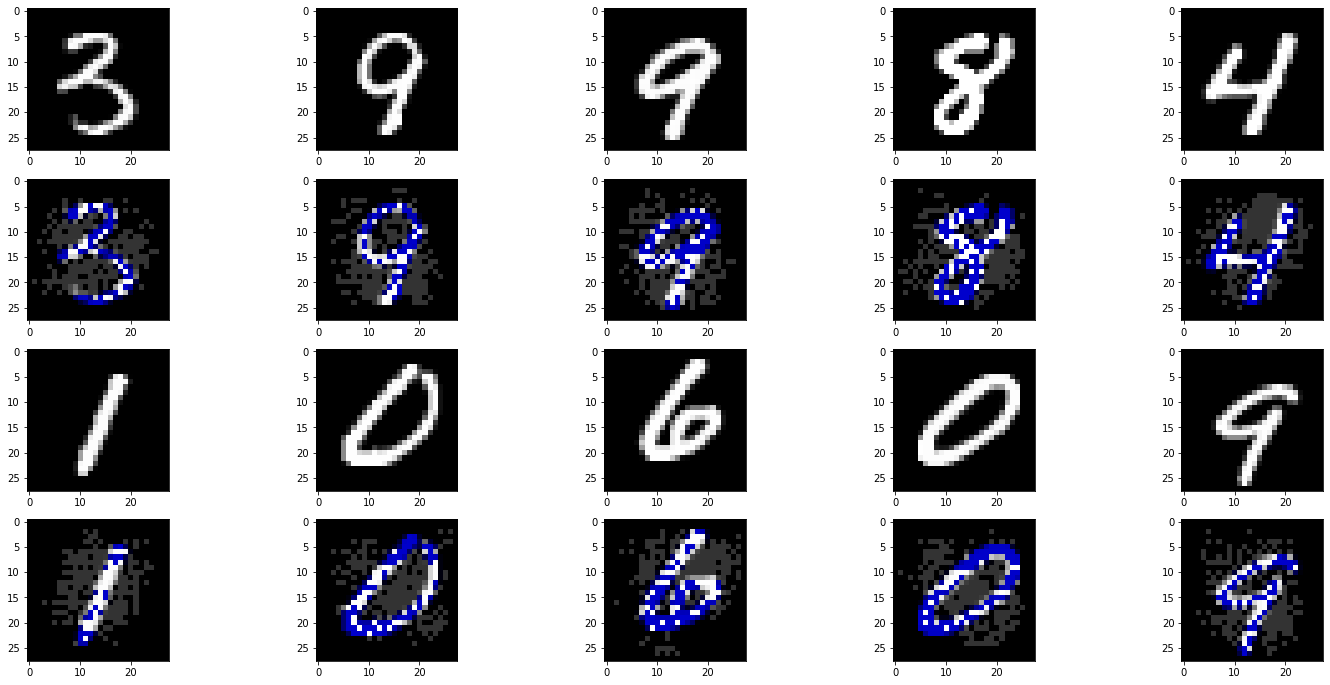

In [25]:
show_some_digits(x_test[:10], feature_mask[:10])

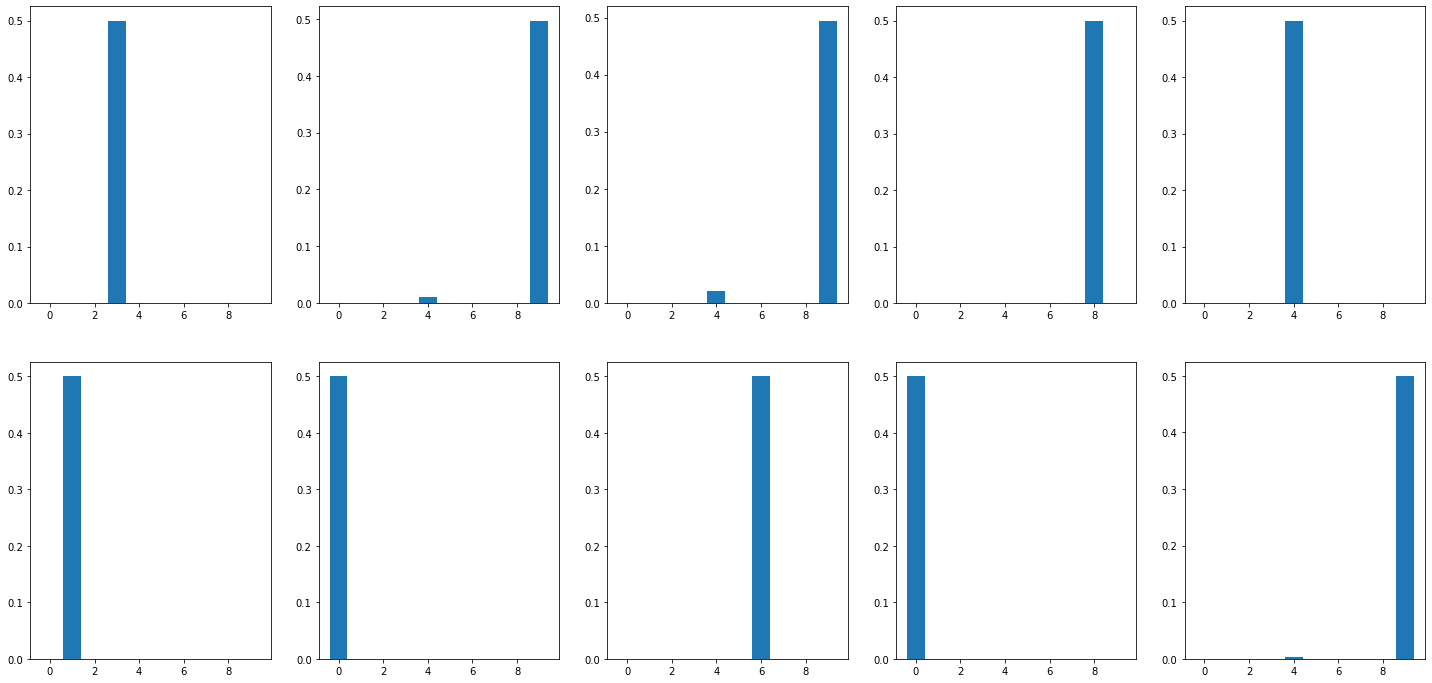

In [26]:
rng, dropout_rng = jax.random.split(rng) 
rngs_iter = {'dropout': dropout_rng,}
preds = pred(x_test[:10] * feature_mask[:10].reshape(-1,28,28,1), state.params, rngs_iter)
show_preds(expit(preds))

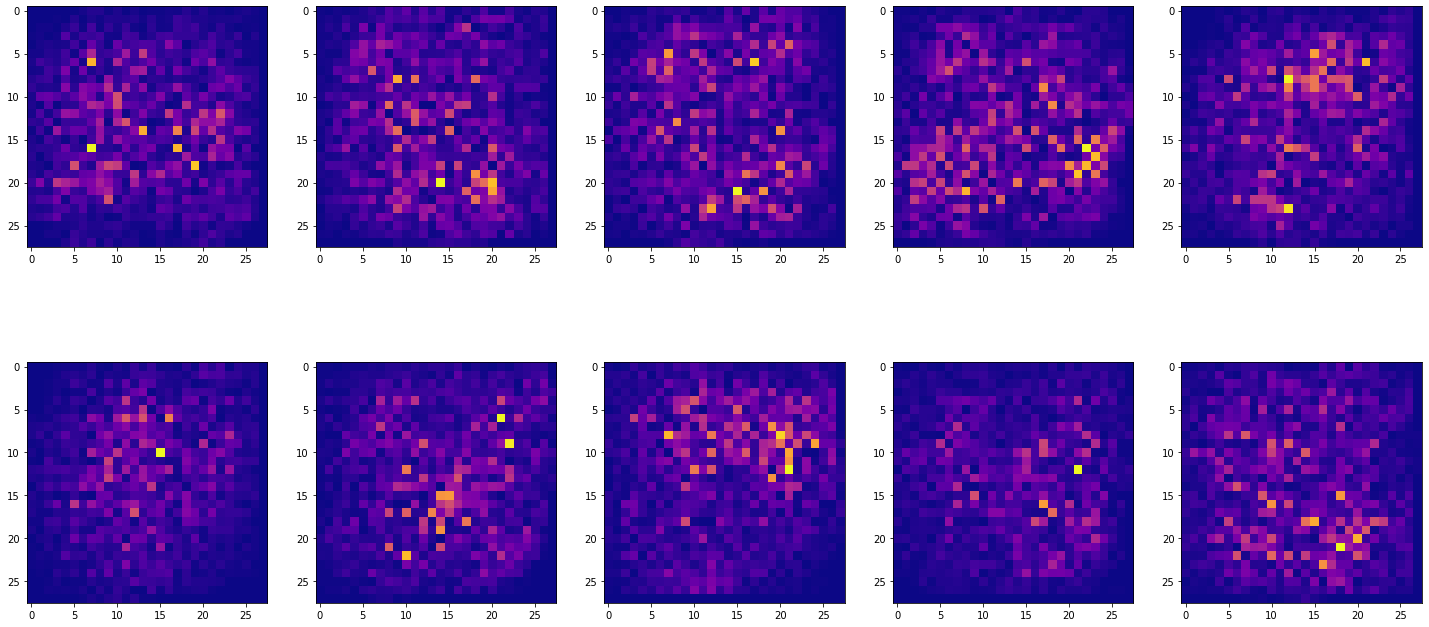

In [27]:
show_grad_heatmap(grads[:10])